In [1]:
# z5484442
# Hongyin Zhou
# COMP9414 Assignment 1 – Artificial neural networks

In [2]:
# Import common libraries
import pandas as pd
import numpy as np
import random
import time
import os
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, metrics
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [3]:
# Load data
df = pd.read_csv("Amazon_temperature_student.csv")
thres = pd.read_csv("thresholds.csv")

In [4]:
df.head()

,year,month,temperature,TSA,ENSO,NAO,TNA
0,1982,1,25.938068,0.03,0.13,-1.55,0.19
1,1982,10,27.525936,-0.11,1.99,-0.29,-0.34
2,1982,11,27.586092,-0.28,1.92,1.55,-0.46
3,1982,12,27.096022,-0.17,2.20,1.56,-0.50
4,1982,2,25.861292,-0.20,-0.17,0.86,-0.07


In [5]:
thres.head()

,month,threshold
0,1,27.205489
1,2,26.782966
2,3,26.590744
3,4,26.645223
4,5,26.712053


### 1.1 Detect & manipulate missing values

In [6]:
# Identify missing values
print("Main DataFrame contains NaNs:", df.isna().sum().sum() > 0)
print("Threshold DataFrame contains NaNs:", thres.isna().sum().sum() > 0)

Main DataFrame contains NaNs: False
Threshold DataFrame contains NaNs: False


In [7]:
df = df.sort_values(by=['year', 'month'], ascending=[True, True])
df.describe()

,year,month,temperature,TSA,ENSO,NAO,TNA
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,2002.000000,6.500000,27.058313,0.262033,-0.059837,0.033394,0.192541
std,11.844202,3.455566,0.666328,0.334739,0.898251,1.050174,0.377868
min,1982.000000,1.000000,25.531697,-0.800000,-2.050000,-3.140000,-0.890000
25%,1992.000000,3.750000,26.565037,0.067500,-0.692500,-0.660000,-0.080000
50%,2002.000000,6.500000,27.008143,0.280000,-0.140000,0.110000,0.240000
75%,2012.000000,9.250000,27.507468,0.482500,0.472500,0.762500,0.470000
max,2022.000000,12.000000,28.809258,1.280000,2.720000,2.560000,1.400000


### 1.2 Data preparation

In [8]:
# Merge temperature data with thresholds on 'month'
df = df.merge(thres, on='month', how='left')
print(df.head())

   year  month  temperature   TSA  ENSO   NAO   TNA  threshold
0  1982      1    25.938068  0.03  0.13 -1.55  0.19  27.205489
1  1982      2    25.861292 -0.20 -0.17  0.86 -0.07  26.782966
2  1982      3    26.212032 -0.21  0.13  0.80 -0.07  26.590744
3  1982      4    26.226341 -0.35  0.21 -0.04 -0.16  26.645223
4  1982      5    26.316759 -0.37  0.45 -0.44 -0.03  26.712053


In [9]:
# Create binary column: Hot=1 if temperature > threshold
df['Hot'] = (df['temperature'] > df['threshold']).astype(int)
print(df.head())

   year  month  temperature   TSA  ENSO   NAO   TNA  threshold  Hot
0  1982      1    25.938068  0.03  0.13 -1.55  0.19  27.205489    0
1  1982      2    25.861292 -0.20 -0.17  0.86 -0.07  26.782966    0
2  1982      3    26.212032 -0.21  0.13  0.80 -0.07  26.590744    0
3  1982      4    26.226341 -0.35  0.21 -0.04 -0.16  26.645223    0
4  1982      5    26.316759 -0.37  0.45 -0.44 -0.03  26.712053    0


In [10]:
# Combine year and month into a Period type for easy indexing
df['yearmonth'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str)).dt.to_period('M')
df.set_index('yearmonth', inplace=True)

# Drop unnecessary columns
df.drop(columns=["threshold"], inplace=True)
df.drop(columns=['year'], inplace=True)

In [11]:
# Month cyclic encoding
df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)
# Drop month column
df.drop(columns=['month'], inplace=True)

In [12]:
print(df.head())

           temperature   TSA  ENSO   NAO   TNA  Hot  month_sin     month_cos
yearmonth                                                                   
1982-01      25.938068  0.03  0.13 -1.55  0.19    0   0.000000  1.000000e+00
1982-02      25.861292 -0.20 -0.17  0.86 -0.07    0   0.500000  8.660254e-01
1982-03      26.212032 -0.21  0.13  0.80 -0.07    0   0.866025  5.000000e-01
1982-04      26.226341 -0.35  0.21 -0.04 -0.16    0   1.000000  6.123234e-17
1982-05      26.316759 -0.37  0.45 -0.44 -0.03    0   0.866025 -5.000000e-01


### 1.3 Detect & manipulate outliers

In [13]:
# Calculate the variation range for each column
variation_summary = df.describe().loc[['min', 'max']]
variation_summary.loc['range'] = variation_summary.loc['max'] - variation_summary.loc['min']
print(f"Variation Range Summary:\n",variation_summary)

Variation Range Summary:
        temperature   TSA  ENSO   NAO   TNA  Hot  month_sin  month_cos
min      25.531697 -0.80 -2.05 -3.14 -0.89  0.0       -1.0       -1.0
max      28.809258  1.28  2.72  2.56  1.40  1.0        1.0        1.0
range     3.277561  2.08  4.77  5.70  2.29  1.0        2.0        2.0


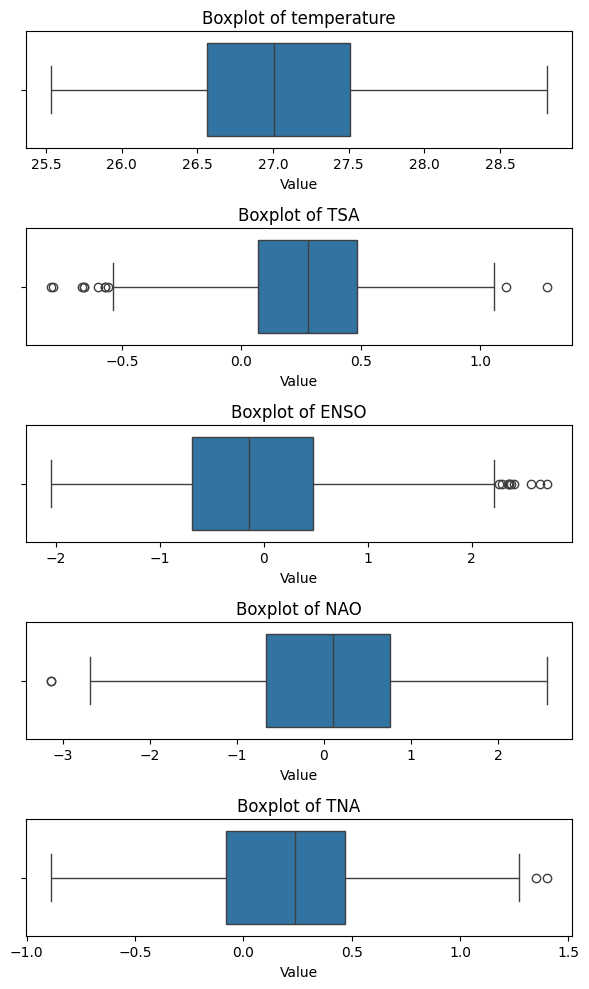

In [14]:
# Boxplots for outlier visualization
columns = ['temperature', 'TSA', 'ENSO', 'NAO', 'TNA']
plt.figure(figsize=(6, 10))
for i, col in enumerate(columns, 1):
    plt.subplot(5, 1, i) 
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Value')
plt.tight_layout()
plt.show()

> Locating and counting outliers using the definition from the following equations:

$Interquartile range (IQR) = Q3 - Q1$

$lowerbound = Q1 - 1.5 * IQR$

$upperbound = Q3 + 1.5 * IQR$

In [15]:
# IQR-based outlier detection
outlier_flags = pd.DataFrame(index=df.index)
for col in columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Outliers（True/False）
    outlier_flags[col + '_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)
# Print all line contains at least one outlier
outliers_all = df[outlier_flags.any(axis=1)]
print(outliers_all)
# Print percentage of outlier rows
print(len(outliers_all)/df.shape[0]*100)
# Decision: Meteorological data often contains natural variability; outliers are retained.

           temperature   TSA  ENSO   NAO   TNA  Hot     month_sin  \
yearmonth                                                           
1982-08      26.661893 -0.57  0.73  0.21 -0.30    0 -5.000000e-01   
1983-01      27.151059  0.33  2.35  1.34 -0.36    0  0.000000e+00   
1992-04      26.547066 -0.57  1.20  1.88 -0.29    0  1.000000e+00   
1992-05      26.892269 -0.66  1.04  2.49 -0.18    1  8.660254e-01   
1992-06      26.608380 -0.80  0.58  0.51 -0.11    0  5.000000e-01   
1992-07      26.022271 -0.60  0.22  0.19 -0.01    0  1.224647e-16   
1992-08      26.460473 -0.66  0.05  0.97 -0.23    0 -5.000000e-01   
1992-09      26.922605 -0.56 -0.06 -0.28 -0.21    0 -8.660254e-01   
1992-11      27.219997 -0.79 -0.28  1.12 -0.30    0 -8.660254e-01   
1993-07      26.387088  0.05  0.23 -3.14 -0.17    0  1.224647e-16   
1997-06      27.063056 -0.67  1.09 -1.17  0.54    1  5.000000e-01   
1997-10      28.461560  0.69  2.36 -1.34  0.59    1 -1.000000e+00   
1997-11      28.106471  0.79  2.41

> The proportion of outliers is around 5.08%, however, this is the statistical data from multiple meteorological phenomena. Since meteorological phenomena are inherently unstable, these abnormal values ​​are temporarily retained without modification.

### 1.4 Data Visualiztion

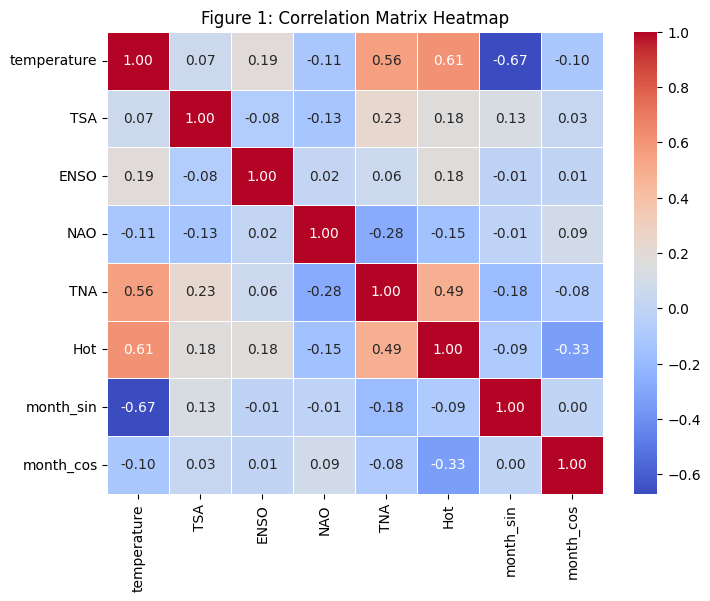

In [16]:
# Plot correlation matrix
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Figure 1: Correlation Matrix Heatmap')
plt.show()

C:\Users\13512\AppData\Local\Temp\ipykernel_23868\1870118147.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='Hot', data=hot_counts, palette='coolwarm')


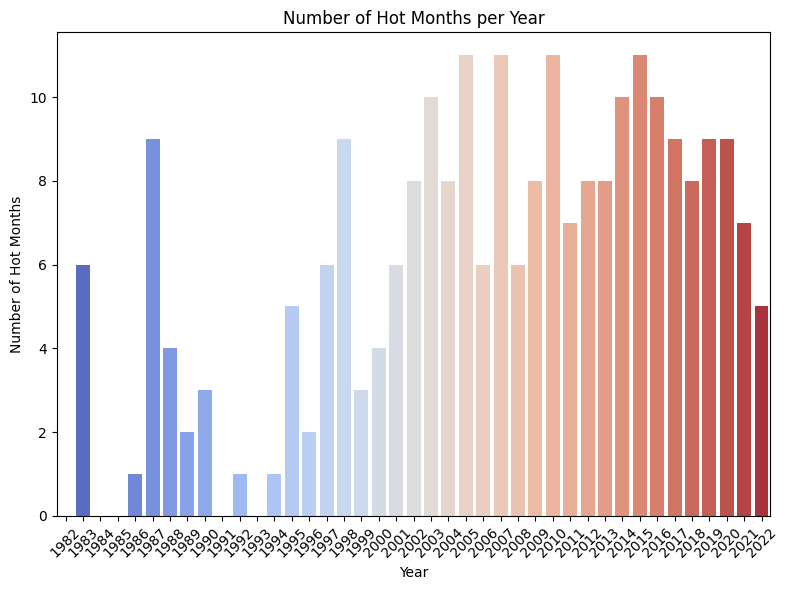

In [17]:
# Bar plot for the num of 'HOT' months in each year
df.reset_index(inplace=True)
df['year'] = df['yearmonth'].dt.year 
hot_counts = df.groupby('year')['Hot'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='year', y='Hot', data=hot_counts, palette='coolwarm')
plt.title('Number of Hot Months per Year')
plt.xlabel('Year')
plt.ylabel('Number of Hot Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Part 2 Classification (Hot event detection)

#### 2.1 Model pre-processing

In [18]:
df.drop(columns=['yearmonth'], inplace=True)
class_df = df.drop(columns=["year"])
X = class_df.drop(columns=["Hot"], axis=1)
y = class_df["Hot"]

In [19]:
print(X)

     temperature   TSA  ENSO   NAO   TNA  month_sin     month_cos
0      25.938068  0.03  0.13 -1.55  0.19   0.000000  1.000000e+00
1      25.861292 -0.20 -0.17  0.86 -0.07   0.500000  8.660254e-01
2      26.212032 -0.21  0.13  0.80 -0.07   0.866025  5.000000e-01
3      26.226341 -0.35  0.21 -0.04 -0.16   1.000000  6.123234e-17
4      26.316759 -0.37  0.45 -0.44 -0.03   0.866025 -5.000000e-01
..           ...   ...   ...   ...   ...        ...           ...
487    27.745835  0.38 -0.97  1.76  0.47  -0.500000 -8.660254e-01
488    27.943517  0.35 -1.07 -1.42  0.62  -0.866025 -5.000000e-01
489    28.347488  0.52 -0.99 -0.27  0.50  -1.000000 -1.836970e-16
490    27.701829  0.51 -0.90  0.59  0.33  -0.866025  5.000000e-01
491    27.099927  0.60 -0.85 -0.22  0.47  -0.500000  8.660254e-01

[492 rows x 7 columns]


In [20]:
# Split into train (60%), validation (20%), test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=888)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=888)
print(f"Train samples: {len(y_train)}, Validation samples: {len(y_valid)}, Test samples: {len(y_test)}")

Train samples: 294, Validation samples: 99, Test samples: 99


In [21]:
# Initialize the StandardScaler (for input features only)
scaler = StandardScaler()
# Transform training, validation and test data using the same scaler
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [22]:
print(X_train.columns)
print(X_train.shape)

Index(['temperature', 'TSA', 'ENSO', 'NAO', 'TNA', 'month_sin', 'month_cos'], dtype='object')
(294, 7)


#### 2.2 Model construction

In [23]:
def create_modelC(seed=888):
    random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    #model.add(Dense(3, activation='relu', kernel_regularizer=l2(0.001)))
    # Hidden layer: 3 neurons, LeakyReLU activation, L2 weight regularization
    model.add(Dense(3, activation='leaky_relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

> The `create_modelC` function constructs a neural network model using TensorFlow and Keras. It initializes the model with a specific seed for reproducibility. The model consists of an input layer, one hidden layers with Leaky ReLU activation functions (3 units), and an output layer with a sigmoid activation function for binary classification.

In [24]:
model_class = create_modelC()
model_class.summary()
total_params = model_class.count_params()
print(f"Total trainable parameters: {total_params}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)

Total trainable parameters: 28


> Rule of Thumb for Model Complexity

A general rule of thumb for the number of parameters in a model is:

$ \text{Number of parameters} < \frac{\text{number of samples}}{10} $

Given: Number of samples = 294

The maximum number of parameters should be:

$\text{Max number of parameters} = \frac{294}{10} = 29.4 $

The maximum number of parameters should be approximately 29. Thus, applied 28 parameters to my model.

In [25]:
# Compile the model
model_class.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy",
              metrics=["accuracy", metrics.Precision(), metrics.Recall(), metrics.AUC()])
# Add EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', mode="min", patience=10, restore_best_weights=True, verbose=1)

# Train the model
start_time_fit = time.time()
history_class = model_class.fit(X_train_scaled,y_train, epochs=100, verbose=0, batch_size=32, 
                    validation_data=(X_valid_scaled,y_valid), callbacks=[early_stop]);
end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 47.
Model fitting time: 5.999880790710449 seconds


#### 2.3 Model evaluation

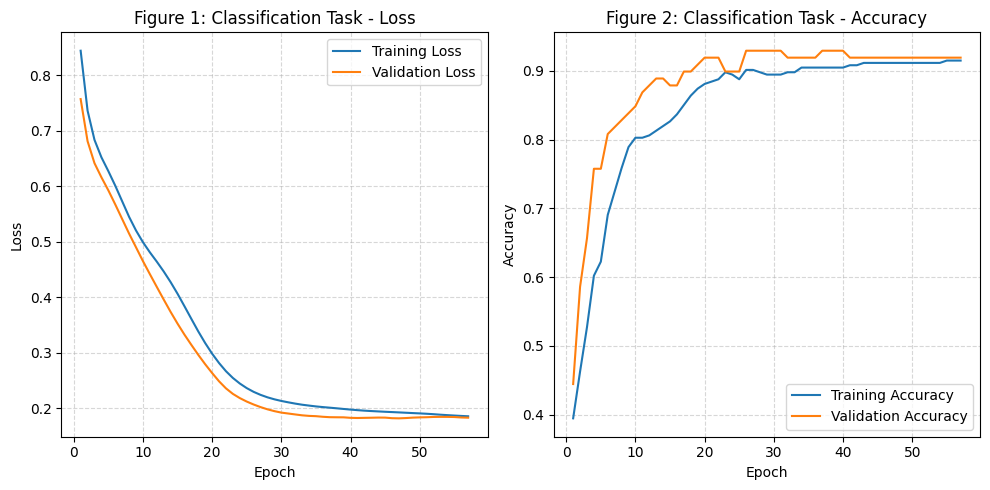

In [26]:
# Plotting the loss and accuracy (Accuracy vs Epochs Curve)
epochs = range(1, len(history_class.history['loss']) + 1)
plt.figure(figsize=(10, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_class.history['loss'], label='Training Loss')
plt.plot(epochs, history_class.history['val_loss'], label='Validation Loss')
plt.title('Figure 1: Classification Task - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_class.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_class.history['val_accuracy'], label='Validation Accuracy')
plt.title('Figure 2: Classification Task - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Predict probabilities and convert to class predictions (on test sets)
y_pred_prob = model_class.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_prob > 0.5).astype("int32")
# Evaluate using model's metrics
test_results = model_class.evaluate(X_test_scaled, y_test, verbose=0)
test_loss, test_accuracy, test_precision, test_recall, test_auc = test_results
# Compute additional metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
# Create a DataFrame for display
table_data = {
    "Metric": ["Hot event classification"], "Accuracy": [f"{test_accuracy * 100:.2f}%"],
    "Precision": [f"{test_precision * 100:.2f}%"], "Balanced Accuracy": [f"{balanced_acc * 100:.2f}%"],
    "Specificity": [f"{specificity:.4f}"], "Numbers of Samples": [len(y_test)]
}

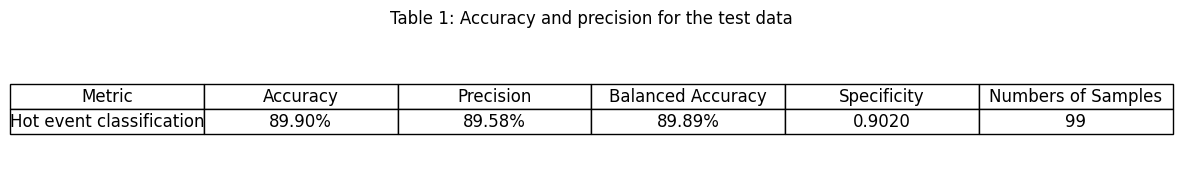

In [28]:
# Plot Table 1: Accuracy and precision for the test data
report = pd.DataFrame(table_data)
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
tb = ax.table(cellText=report.values, colLabels=report.columns, cellLoc='center', loc='center')
tb.auto_set_font_size(False)
tb.set_fontsize(12)
tb.scale(1.5, 1.5)
plt.title("Table 1: Accuracy and precision for the test data")
plt.show()

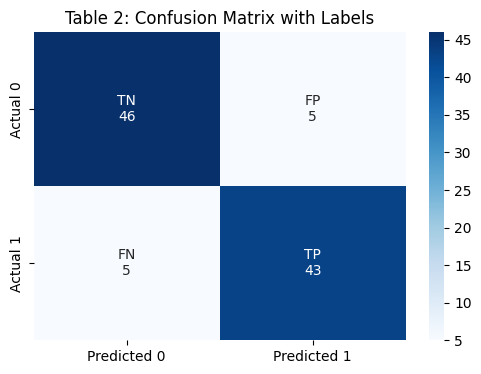

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        51
           1       0.90      0.90      0.90        48

    accuracy                           0.90        99
   macro avg       0.90      0.90      0.90        99
weighted avg       0.90      0.90      0.90        99



In [29]:
# Confusion matrix with labels
cm = confusion_matrix(y_test, y_pred)
labels = [['TN\n{}'.format(tn), 'FP\n{}'.format(fp)],
          ['FN\n{}'.format(fn), 'TP\n{}'.format(tp)]]
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=np.array(labels), fmt='', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Table 2: Confusion Matrix with Labels')
plt.show()
# Classification report
print(classification_report(y_test, y_pred))

c:\Users\13512\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


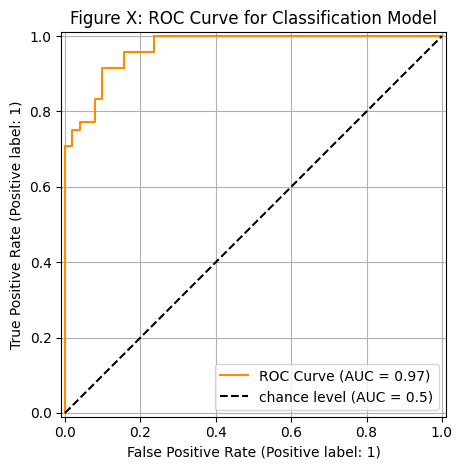

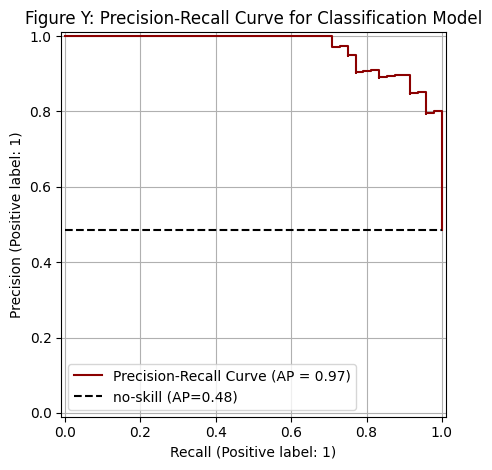

In [30]:
# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob, name="ROC Curve", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("Figure X: ROC Curve for Classification Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_pred_prob, name="Precision-Recall Curve", color="darkred")
plt.plot([0, 1], [sum(y_test)/len(y_test), sum(y_test)/len(y_test)], "k--",
         label=f"no-skill (AP={sum(y_test)/len(y_test):.2f})")
plt.title("Figure Y: Precision-Recall Curve for Classification Model")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# Save the model & scaler
os.makedirs("models", exist_ok=True)
model_class.save("models/taskA_classification_model.keras")
joblib.dump(scaler, "models/taskA_classification_scaler.pkl")
# Columns used for classification tasks (7: including temperature)
expected_columns_classification = ['temperature', 'ENSO', 'TSA', 'TNA', 'NAO', 'month_sin', 'month_cos']
joblib.dump(expected_columns_classification, "models/feature_columns_classification.pkl")

['models/feature_columns_classification.pkl']

### Part 3 Regression (Temperature prediction)

#### 3.1 Random-Split Model

In [32]:
# Prepare regression dataset: drop year and Hot, keep temperature as target
regres_df = df.drop(columns=["year", "Hot"])
Xr = regres_df.drop(columns=["temperature"], axis=1)
yr = regres_df["temperature"]

In [33]:
# Split into train (60%), validation (20%), test (20%)
Xr_temp, Xr_test, yr_temp, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=888)
Xr_train, Xr_valid, yr_train, yr_valid = train_test_split(Xr_temp, yr_temp, test_size=0.25, random_state=888)
print(f"Train samples: {len(yr_train)}, Validation samples: {len(yr_valid)}, Test samples: {len(yr_test)}")

Train samples: 294, Validation samples: 99, Test samples: 99


In [34]:
# Feature scaling using StandardScaler
scaler_random = StandardScaler()
Xr_train_scaled = scaler_random.fit_transform(Xr_train)
Xr_valid_scaled = scaler_random.transform(Xr_valid)
Xr_test_scaled = scaler_random.transform(Xr_test)

In [35]:
def create_modelR(seed=888):
    random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential()
    model.add(Input(shape=(Xr_train_scaled.shape[1],)))
    model.add(Dense(3, activation='leaky_relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='linear'))  # Linear for regression
    
    return model

> The `create_modelR` function constructs a neural network model using TensorFlow and Keras. It initializes the model with a specific seed for reproducibility. The model consists of an input layer, one hidden layer with Leaky ReLU activation functions (3 units), and an output layer with a Linear activation function for regression tasks.

In [36]:
model_regress_random = create_modelR()
model_regress_random.summary()
total_params = model_regress_random.count_params()
print(f"Total trainable parameters: {total_params}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

Total trainable parameters: 25


In [37]:
# Compile the model with MSE loss and MAE metric
model_regress_random.compile(optimizer=optimizers.Adam(learning_rate=0.5), loss="mse", metrics=["mae"])
# Early stopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', mode="min", patience=5, restore_best_weights=True, verbose=1)

# Train the model
start_time_fit = time.time()
history_regress_random = model_regress_random.fit(Xr_train_scaled,yr_train, epochs=50, verbose=0, batch_size=32, 
                                                  validation_data=(Xr_valid_scaled,yr_valid), callbacks=[early_stop]);
end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.
Model fitting time: 1.6825439929962158 seconds


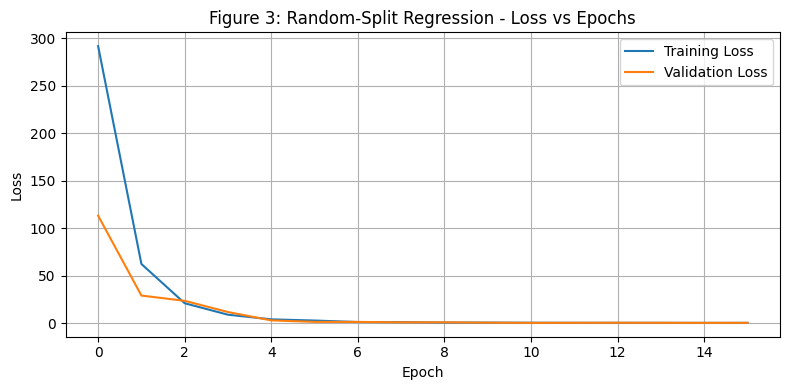

In [38]:
# Plot training loss vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_regress_random.history['loss'], label='Training Loss')
plt.plot(history_regress_random.history['val_loss'], label='Validation Loss')
plt.title('Figure 3: Random-Split Regression - Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
                    Metric   Value
0                     RMSE  0.4502
1                      MAE  0.3203
2  Pearson Correlation (r)  0.8067


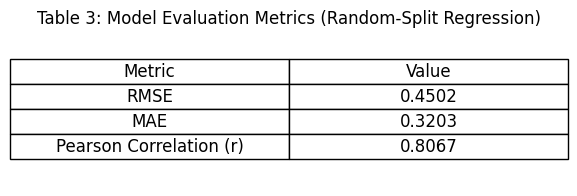

In [39]:
# Predict on test set
# Flatten prediction results for easier plotting and analysis
yr_pred = model_regress_random.predict(Xr_test_scaled).flatten()
# Evaluate using built-in metrics
test_loss, test_mae = model_regress_random.evaluate(Xr_test_scaled, yr_test, verbose=0)
test_rmse = np.sqrt(test_loss)
pearson_corr, _ = pearsonr(yr_test, yr_pred)
# Print evaluation metrics in a table
results_random = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "Pearson Correlation (r)"],
    "Value": [f"{test_rmse:.4f}", f"{test_mae:.4f}", f"{pearson_corr:.4f}"]
})
print(results_random)
# Plot the table
fig, ax = plt.subplots(figsize=(6, 2)) 
ax.axis('off')
tb = ax.table(cellText=results_random.values, colLabels=results_random.columns, loc='center', cellLoc='center')
tb.auto_set_font_size(False)
tb.set_fontsize(12)
tb.scale(1.2, 1.5)
plt.title("Table 3: Model Evaluation Metrics (Random-Split Regression)")
plt.show()

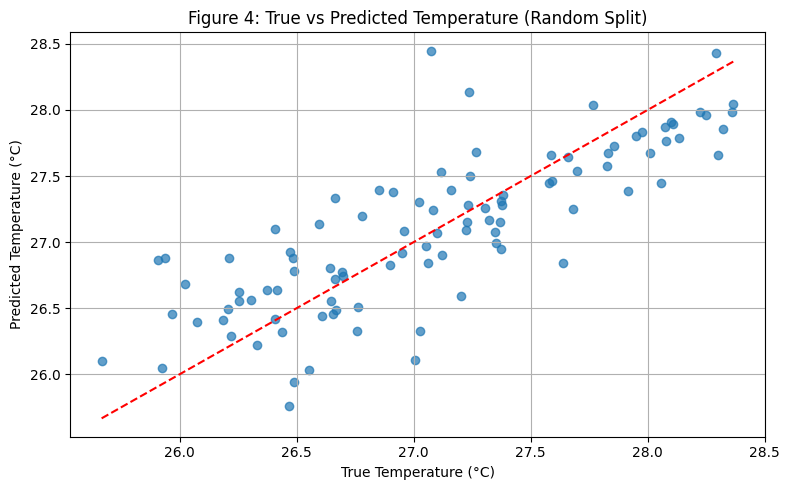

In [40]:
# Scatter plot of true vs predicted values
plt.figure(figsize=(8, 5))
plt.scatter(yr_test, yr_pred, alpha=0.7)
plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], 'r--')
plt.title("Figure 4: True vs Predicted Temperature (Random Split)")
plt.xlabel("True Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
# Save the model and scaler
model_regress_random.save("models/taskB_regression_model_random.keras")
joblib.dump(scaler_random, "models/taskB_regression_scaler_random.pkl")
# Columns used by regression tasks (6: excluding temperature)
expected_columns_regression = ['ENSO', 'TSA', 'TNA', 'NAO', 'month_sin', 'month_cos']
joblib.dump(expected_columns_regression, "models/feature_columns_regression.pkl")
joblib.dump(expected_columns_regression, "models/feature_columns_regression.pkl")

['models/feature_columns_regression.pkl']

#### 3.2 Year-Wise-Split Model

In [42]:
df_with_year = df.copy()
# Get unique years and randomly split them into train/validation/test years
unique_years = df_with_year['year'].unique()
np.random.shuffle(unique_years)  # Shuffle to ensure non-consecutive
# Split the year by 60%/20%/20%
train_years = unique_years[:int(0.6 * len(unique_years))]
valid_years = unique_years[int(0.6 * len(unique_years)):int(0.8 * len(unique_years))]
test_years = unique_years[int(0.8 * len(unique_years)):]

In [43]:
# Filter data by year
def get_year_split_data(df, years, feature_cols):
    mask = df['year'].isin(years)   # Boolean mask for selected years
    X = df.loc[mask, feature_cols]  # Select feature columns for those years
    y = df.loc[mask, 'temperature'] # Select target (temperature) column
    return X, y
# Get the list of feature columns by dropping 'year' and 'temperature'
feature_cols = df.columns.drop(['year', 'temperature'])
# Extract train/validation/test sets using the function
X_year_train, y_year_train = get_year_split_data(df_with_year, train_years, feature_cols)
X_year_valid, y_year_valid = get_year_split_data(df_with_year, valid_years, feature_cols)
X_year_test, y_year_test = get_year_split_data(df_with_year, test_years, feature_cols)

In [44]:
# Get the list of feature column names used during training
feature_columns = Xr_train.columns.tolist()
# Filter out the same columns and keep the order consistent
X_year_train_filtered = X_year_train[feature_columns]
X_year_valid_filtered = X_year_valid[feature_columns]
X_year_test_filtered = X_year_test[feature_columns]
# Use the previously saved scaler to normalize
X_year_train_scaled = scaler_random.transform(X_year_train_filtered)
X_year_valid_scaled = scaler_random.transform(X_year_valid_filtered)
X_year_test_scaled = scaler_random.transform(X_year_test_filtered)

In [45]:
# Create a StandardScaler for normalizing the target variable (y)
scaler_yearwise_target = StandardScaler()
# Fit and transform the training target values
# reshape(-1, 1) is required because scaler expects 2D input; flatten() returns it to 1D
y_year_train_scaled = scaler_yearwise_target.fit_transform(y_year_train.values.reshape(-1, 1)).flatten()
# Fit only on training set, transform others
y_year_valid_scaled = scaler_yearwise_target.transform(y_year_valid.values.reshape(-1, 1)).flatten()
y_year_test_scaled = scaler_yearwise_target.transform(y_year_test.values.reshape(-1, 1)).flatten()

In [46]:
# Create a model with the same architecture as the random partitioning model
model_regress_yearwise = create_modelR(X_year_train.shape[1])
model_regress_yearwise.compile(optimizer=optimizers.Adam(learning_rate=0.2), loss="mse", metrics=["mae"])

# Early stopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', mode="min", patience=10, restore_best_weights=True, verbose=1)
# Train the model
start_time_fit = time.time()
history_regress_yearwise = model_regress_yearwise.fit(
    X_year_train_scaled, y_year_train_scaled, epochs=50, batch_size=32,
    validation_data=(X_year_valid_scaled, y_year_valid_scaled), callbacks=[early_stop], verbose=0)
end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 26.
Model fitting time: 3.2346744537353516 seconds


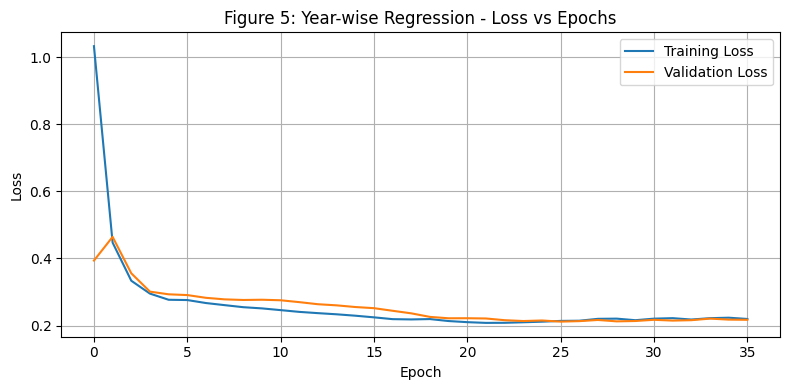

In [47]:
# Plot training loss vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_regress_yearwise.history['loss'], label='Training Loss')
plt.plot(history_regress_yearwise.history['val_loss'], label='Validation Loss')
plt.title('Figure 5: Year-wise Regression - Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E45FC43BA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
                    Metric   Value
0                     RMSE  0.4273
1                      MAE  0.3412
2  Pearson Correlation (r)  0.9004


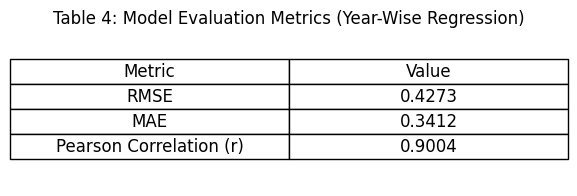

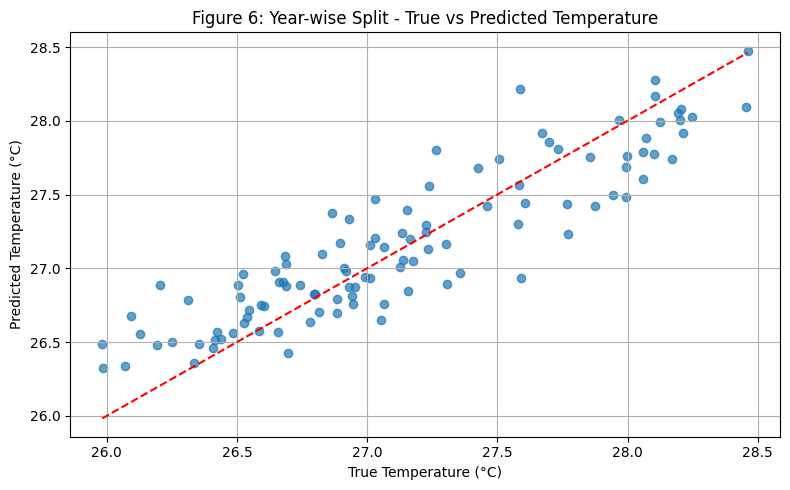

In [48]:
# Prediction + Inverse Transformation
y_year_pred_scaled = model_regress_yearwise.predict(X_year_test_scaled)
y_year_pred = scaler_yearwise_target.inverse_transform(y_year_pred_scaled).flatten()
# Evaluation Metrics Calculation
test_loss_year, test_mae_year = model_regress_yearwise.evaluate(X_year_test_scaled, y_year_test_scaled, verbose=0)
test_rmse_year = np.sqrt(test_loss_year)
pearson_corr_year, _ = pearsonr(y_year_test, y_year_pred)
# Print evaluation form
results_yearwise = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "Pearson Correlation (r)"],
    "Value": [f"{test_rmse_year:.4f}", f"{test_mae_year:.4f}", f"{pearson_corr_year:.4f}"]
})
print(results_yearwise)
# Metric Table
fig, ax = plt.subplots(figsize=(6, 2)) 
ax.axis('off')
tb = ax.table(cellText=results_yearwise.values, colLabels=results_yearwise.columns, loc='center', cellLoc='center')
tb.auto_set_font_size(False)
tb.set_fontsize(12)
tb.scale(1.2, 1.5)
plt.title("Table 4: Model Evaluation Metrics (Year-Wise Regression)")
plt.show()
# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(y_year_test, y_year_pred, alpha=0.7)
plt.plot([y_year_test.min(), y_year_test.max()], 
         [y_year_test.min(), y_year_test.max()], 'r--')
plt.title("Figure 6: Year-wise Split - True vs Predicted Temperature")
plt.xlabel("True Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# Save the model and scaler
model_regress_yearwise.save("models/taskB_regression_model_yearwise.keras")
joblib.dump(scaler_yearwise_target, "models/taskB_regression_scaler_yearwise_target.pkl")

['models/taskB_regression_scaler_yearwise_target.pkl']

### Part 4 Script for generalization (hidden) dataset

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


c:\Users\13512\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\13512\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\13512\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
=== Classification Results ===
Confusion Matrix:
[[199  18]
 [  4  19]]

Balanced Accuracy: 0.8715688238829894
Precision: 0.5135135135135135
Recall: 0.5135135135135135
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       217
           1       0.51      0.83      0.63        23

    accuracy                           0.91       240
   macro avg       0.75      0.87      0.79       240
weighted avg       0.94      0.91      0.92       240



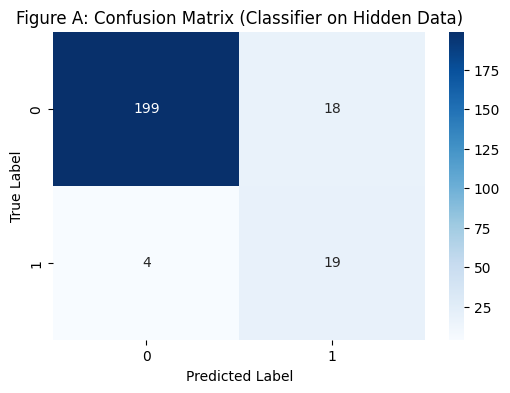

=== Random-Split Regressor ===
MAE: 0.8564
Pearson Correlation (r): 0.4364
=== Year-Wise Regressor ===
MAE: 0.8347
Pearson Correlation (r): 0.4020


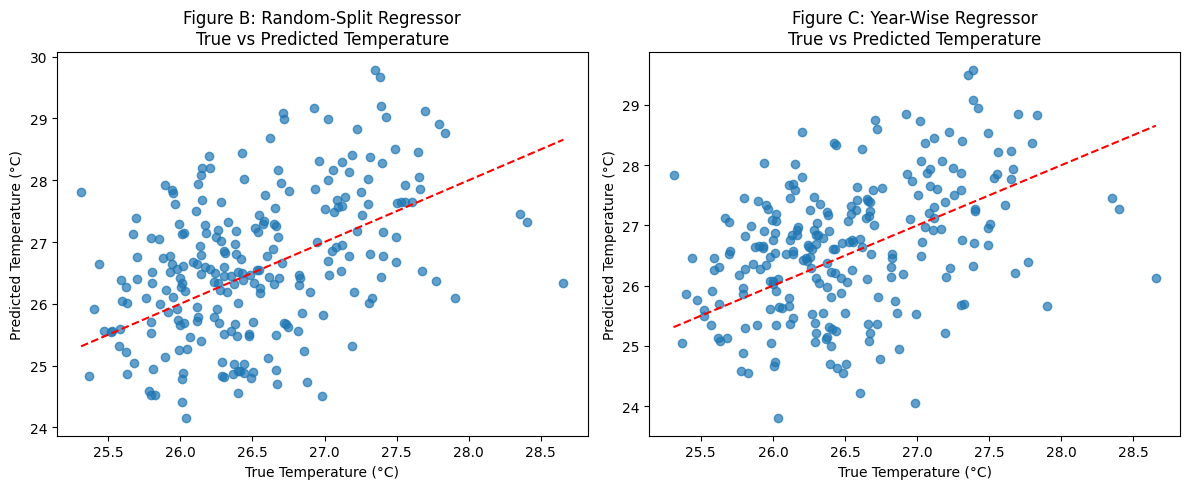

In [50]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, classification_report
from tensorflow import keras
from keras.models import load_model
from scipy.stats import pearsonr

# -----------------------------
# Step 1: Load Hidden Test Data
# -----------------------------
try:
    hidden_data_df = pd.read_csv("Amazon_temperature_testing.csv")
    hidden_data_thres = pd.read_csv("thresholds.csv")
except FileNotFoundError:
    raise FileNotFoundError("hidden_test.csv or threshold.csv not found.")

#hidden_data = hidden_data.sort_values(by=['year', 'month']).reset_index(drop=True)
X_hidden_df = hidden_data_df.copy()
X_hidden_thres = hidden_data_thres.copy()

# -----------------------------
# Step 2: Create binary 'Hot' column
# -----------------------------
# Merge hidden test data with thresholds by 'month'
hidden_data_labeled = pd.merge(hidden_data_df, hidden_data_thres, on='month', how='left')
# Define Hot=1 if temperature > threshold
hidden_data_labeled['Hot'] = (hidden_data_labeled['temperature'] > hidden_data_labeled['threshold']).astype(int)

X_hidden_df = hidden_data_labeled.drop(columns=['threshold'])  

# -----------------------------
# Step 3: Feature Engineering (Cyclic Encoding for Month)
# -----------------------------
def cyclic_encode_month(month):
    month_norm = 2 * np.pi * (month - 1) / 12
    return np.sin(month_norm), np.cos(month_norm)

if 'month' in X_hidden_df.columns:
    X_hidden_df['month_sin'], X_hidden_df['month_cos'] = zip(*X_hidden_df['month'].apply(cyclic_encode_month))
    X_hidden_df = X_hidden_df.drop(columns=['month'])

# -----------------------------
# Step 4: Load Expected Feature Columns
# -----------------------------
try:
    expected_columns_class = joblib.load("models/feature_columns_classification.pkl")  # include temperature
    expected_columns_regress = joblib.load("models/feature_columns_regression.pkl")      # not include temperature
except FileNotFoundError as e:
    raise FileNotFoundError(f"Missing file: {e}. Make sure to save feature columns during training.")

# -----------------------------
# Step 5: Prepare Features for Each Task
# -----------------------------
# Classification：7 inputs（temperature）
X_hidden_class = X_hidden_df[expected_columns_class] 
X_hidden_class = X_hidden_class[expected_columns_class]  

# Regression: 6 inputs（no temperature）
X_hidden_regress = X_hidden_df[expected_columns_regress]
X_hidden_regress = X_hidden_regress[expected_columns_regress]

# -----------------------------
# Step 6: Load All Models and Scalers
# -----------------------------
# Classification
model_class = load_model("models/taskA_classification_model.keras")
scaler_class = joblib.load("models/taskA_classification_scaler.pkl")

# Regression - Random Split
model_regress_random = load_model("models/taskB_regression_model_random.keras")
scaler_regress_random = joblib.load("models/taskB_regression_scaler_random.pkl")

# Regression - Year-Wise Split
model_regress_yearwise = load_model("models/taskB_regression_model_yearwise.keras")
scaler_regress_yearwise_features = joblib.load("models/taskB_regression_scaler_random.pkl")
scaler_regress_yearwise_target = joblib.load("models/taskB_regression_scaler_yearwise_target.pkl")

# -----------------------------
# Step 7: Preprocess Hidden Data Using Saved Scalers
# -----------------------------
# Classification：7 columns
X_hidden_scaled_class = scaler_class.transform(X_hidden_class[expected_columns_class].to_numpy())

# Regression - Random-Split（6 columns）
X_hidden_scaled_random = scaler_regress_random.transform(X_hidden_regress[expected_columns_regress].to_numpy())

# Regression - Year-Wise Split（6 columns）
X_hidden_scaled_yearwise = scaler_regress_yearwise_features.transform(X_hidden_regress[expected_columns_regress].to_numpy())

# -----------------------------
# Step 8: Make Predictions
# -----------------------------
# Classification
y_pred_prob_class = model_class.predict(X_hidden_scaled_class)
y_pred_class = (y_pred_prob_class > 0.5).astype(int).flatten()

# Regression - Random-Split
y_pred_reg_random = model_regress_random.predict(X_hidden_scaled_random).flatten()

# Regression - Year-Wise Split
y_pred_reg_yearwise_scaled = model_regress_yearwise.predict(X_hidden_scaled_yearwise)
y_pred_reg_yearwise = scaler_regress_yearwise_target.inverse_transform(y_pred_reg_yearwise_scaled).flatten()

# -----------------------------
# Step 9: Evaluate on Hidden Test Set (Classification)
# -----------------------------
has_hot_label = 'Hot' in hidden_data_df.columns
has_temperature_label = 'temperature' in hidden_data_df.columns

y_true_class = hidden_data_labeled['Hot']
print("=== Classification Results ===")
print("Confusion Matrix:")
print(confusion_matrix(y_true_class, y_pred_class))
print("\nBalanced Accuracy:", balanced_accuracy_score(y_true_class, y_pred_class))
print("Precision:", precision_score(y_true_class, y_pred_class))
print("Recall:", precision_score(y_true_class, y_pred_class))
print("Classification Report:\n", classification_report(y_true_class, y_pred_class))

# Confusion Matrix for Classifier
cm = confusion_matrix(y_true_class, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Figure A: Confusion Matrix (Classifier on Hidden Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# -----------------------------
# Step 10: Evaluate on Hidden Test Set (Regression)
# -----------------------------
y_true_temp = hidden_data_df['temperature']

def evaluate_regression(y_true, y_pred, title="Regression"):
    mae = np.mean(np.abs(y_true - y_pred))
    r = pearsonr(y_true, y_pred)[0]
    print(f"=== {title} ===")
    print(f"MAE: {mae:.4f}")
    print(f"Pearson Correlation (r): {r:.4f}")

evaluate_regression(y_true_temp, y_pred_reg_random, "Random-Split Regressor")
evaluate_regression(y_true_temp, y_pred_reg_yearwise, "Year-Wise Regressor")

# True vs Predicted for Regression
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_true_temp, y_pred_reg_random, alpha=0.7)
plt.plot([min(y_true_temp), max(y_true_temp)], [min(y_true_temp), max(y_true_temp)], 'r--')
plt.title("Figure B: Random-Split Regressor\nTrue vs Predicted Temperature")
plt.xlabel("True Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")

plt.subplot(1, 2, 2)
plt.scatter(y_true_temp, y_pred_reg_yearwise, alpha=0.7)
plt.plot([min(y_true_temp), max(y_true_temp)], [min(y_true_temp), max(y_true_temp)], 'r--')
plt.title("Figure C: Year-Wise Regressor\nTrue vs Predicted Temperature")
plt.xlabel("True Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")

plt.tight_layout()
plt.show()